In [21]:
import numpy as np
from quspin.operators import hamiltonian
from quspin.basis import boson_basis_1d, tensor_basis
from scipy.linalg import expm
#from quspin.tools.measurements import partial_trace
from scipy import integrate
import matplotlib.pyplot as plt



In [331]:
# Parameters

 # Number of sites in the system
L_sys = 1 

# Number of sites in the bath
L_bath = 2     

# Maximum number of bosons on the site
nmax = 2  

# On-site interaction strength
U = 3.0 

#hopping strength
J = 1.0


mu = U 

Start by setting up the Hamiltonian for the single site system given by:
$$
H_{A} = \frac{U}{2}n(n-1)
$$

In [332]:
# Define the basis for one site with max nmax bosons
basis_sys = boson_basis_1d(L_sys, Nb=None, sps=nmax + 1)

# Define the potential term: U/2 * n(n-1)
potential = [[0.5 * U, 0, 0]]  # Interaction term

# Define the chemical potential term: -mu * n
chemical_potential = [[-0.5*U, 0]]  # Chemical potential term

# Define the static list for the Hamiltonian
static = [
    ["nn", potential],          # Potential term
    ["n", chemical_potential],  # Chemical potential term
]

# Construct the Hamiltonian
H_sys = hamiltonian(static, [], basis=basis_sys, dtype=np.float64)



Hermiticity check passed!
Symmetry checks passed!


In [333]:
# Print the basis states for verification
print("\nBasis states for the system(n values):")
for state in basis_sys.states:
    print(basis_sys.int_to_state(state))


Basis states for the system(n values):
|2>
|1>
|0>


Next we setup the Hamiltonian for the bath which is a Bose-Hubbard model given by:
$$
H_{B} = -J\sum_{i}(b_{i}b^{\dagger}_{i+1}+b_{i}^{\dagger}b_{i+1}) +\frac{U}{2}n(n-1)
$$

In [334]:
# Define the basis for L sites with max nmax bosons
basis_bath = boson_basis_1d(L_bath, Nb=None, sps=nmax + 1)

# Define the hopping term: -J * (b_i^† b_j + h.c.)
hopping = [[-J, i, i + 1] for i in range(L_bath - 1)]  # Nearest-neighbor hopping

# Define the on-site interaction term: U/2 * n_i * (n_i - 1)
interaction = [[0.5 * U, i, i] for i in range(L_bath)]  # On-site interactions

# Define the chemical potential term: -mu * n_i
chemical_potential_bath = [[-mu, i] for i in range(L_bath)]  # Chemical potential

# Define the static list for the Hamiltonian
static = [
    ["+-", hopping],     # Hopping term (b_i^† b_j)
    ["-+", hopping],     # Hopping term (b_j^† b_i)
    ["nn", interaction], # On-site interaction term
    ["n", chemical_potential_bath], # Chemical potential term
]

# Construct the bath Hamiltonian
H_bath = hamiltonian(static, [], basis=basis_bath, dtype=np.float64)




Hermiticity check passed!
Symmetry checks passed!


In [335]:
# Print the basis states for verification
print("\nBasis states for the bath(n values):")
for state in basis_bath.states:  # Print the first 10 states for brevity
    print(basis_bath.int_to_state(state))


Basis states for the bath(n values):
|2 2>
|2 1>
|2 0>
|1 2>
|1 1>
|1 0>
|0 2>
|0 1>
|0 0>


Create a basis for system+bath which is obtained by tensoring all possible basis states

In [336]:
basis_total = tensor_basis(basis_sys, basis_bath)


Construct annihilation and creation operators for system and bath

In [337]:
create_sys = hamiltonian([["+", [[1.0, 0]]]], [], basis=basis_sys, dtype=np.float64, check_herm=False)
annih_sys = hamiltonian([["-", [[1.0, 0]]]], [], basis=basis_sys, dtype=np.float64, check_herm=False)

Symmetry checks passed!
Symmetry checks passed!


In [338]:
create_bath = hamiltonian(
    [["+", [[1.0 if i == 0 else 0.0, i] for i in range(L_bath)]]],
    [],
    basis=basis_bath,
    dtype=np.float64,
    check_herm=False,
    check_pcon=False
)

# Define the annihilation operator explicitly for site 0 of the bath
annih_bath = hamiltonian(
    [["-", [[1.0 if i == 0 else 0.0, i] for i in range(L_bath)]]],
    [],
    basis=basis_bath,
    dtype=np.float64,
    check_herm=False,
    check_pcon=False
)



Symmetry checks passed!
Symmetry checks passed!


In [339]:
create_sys_matrix = create_sys.toarray()
annih_sys_matrix = annih_sys.toarray()

create_bath_matrix = create_bath.toarray()
annih_bath_matrix = annih_bath.toarray()

# Print the operator matrices
print("System Creation Operator Matrix (b^†_sys):")
print(create_sys_matrix)

print("\nSystem Annihilation Operator Matrix (b_sys):")
print(annih_sys_matrix)

print("\nBath Creation Operator Matrix (b^†_bath):")
print(create_bath_matrix)

print("\nBath Annihilation Operator Matrix (b_bath):")
print(annih_bath_matrix)

System Creation Operator Matrix (b^†_sys):
[[0.         1.41421356 0.        ]
 [0.         0.         1.        ]
 [0.         0.         0.        ]]

System Annihilation Operator Matrix (b_sys):
[[0.         0.         0.        ]
 [1.41421356 0.         0.        ]
 [0.         1.         0.        ]]

Bath Creation Operator Matrix (b^†_bath):
[[0.         0.         0.         1.41421356 0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         1.41421356 0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.41421356
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  1.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         1.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         1.        ]
 [0.         0.         0.         0.         0.         0.
  0.  

Create the interaction Hamiltonian between system and bath which is given by:
$$
H_{int} = -J(ab^{\dagger}+a^{\dagger}b)
$$

In [340]:
H_int = -J * (
    np.kron(create_sys.toarray(), annih_bath.toarray()) +
    np.kron(annih_sys.toarray(), create_bath.toarray())
)

The full Hamiltonian for the system+bath is given by:
$$
H_{\text{full}} = H_{A} + H_{B} + H_{int} 
$$

In [341]:
H_full =   np.kron(H_sys.toarray(), np.eye(H_bath.toarray().shape[0])) + np.kron(np.eye(H_sys.toarray().shape[0]), H_bath.toarray())+ H_int 


Intialise the system in the state 
$$
\rho_{A} = |1><1|
$$

In [342]:
# Initialize the system with 1 boson
initial_sys_state = np.zeros((nmax + 1,))
initial_sys_state[1] = 1  # 1 boson in the system
initial_sys_rho = np.outer(initial_sys_state, initial_sys_state.conj())

Initialise the bath in a thermal state

In [343]:
beta = 1.0  # Inverse temperature
H_bath_matrix = H_bath.toarray()
eigenvalues, eigenvectors = np.linalg.eigh(H_bath_matrix)
z_partition = np.sum(np.exp(-beta * eigenvalues))
rho_bath = np.zeros_like(H_bath_matrix)
for i in range(len(eigenvalues)):
    rho_bath += np.exp(-beta * eigenvalues[i]) * np.outer(eigenvectors[:, i], eigenvectors[:, i].conj())
rho_bath /= z_partition  # Normalize the thermal state


The intial state of the joint system+bath is 
$$
\rho_{AB}(0) =\rho_{A}\otimes\rho_{B}
$$

In [344]:
# Construct the initial total density matrix
rho_initial = np.kron(initial_sys_rho, rho_bath)

Perform a quench on the initial state
$$
\rho_{AB}^{Q}(0)\rightarrow a^{\dagger}\rho_{AB}(0)a
$$

In [345]:


I_bath = np.eye(H_bath.toarray().shape[0])

# Expand creation and annihilation operators to the full Hilbert space
create_sys_ext = np.kron(create_sys.toarray(), I_bath)
annih_sys_ext = np.kron(annih_sys.toarray(), I_bath)

# Apply quench operation correctly
rho_quenched = create_sys_ext @ rho_initial @ annih_sys_ext

Function for time evolution in the interaction picture
$$
\rho_{AB}^{I}(t) = U_{I}\rho_{AB}^{I}(0)U_{I}^{\dagger}
$$

In [346]:
def evolve_density_matrix(rho, H, H_sys,H_bath, t):
    """Evolves the density matrix rho up to time t under Hamiltonian H."""
    U_t = expm(-1j * H * t)
    U0_t = expm(-1j * np.kron(H_sys.toarray(), np.eye(H_bath.toarray().shape[0]) ) * t)
    prop_t = (U0_t.conj().T)@U_t
    rho_t = prop_t @ rho @ prop_t.conj().T
    return rho_t




In [357]:
t_stop = 1.0              # final time
num_points = 30            # number of points (including t=0)
time_points = np.linspace(0, t_stop, num_points)


Here, we compute OTOC from quenched Renyi-2 entropy:
$$
S_{A}^{(2)}(t) = -ln\Big({Tr{\rho_{A}^{2}(t)}\Big)}
$$

$$
OTOC(t) = e^{-S_{A}^{2}(t)}
$$

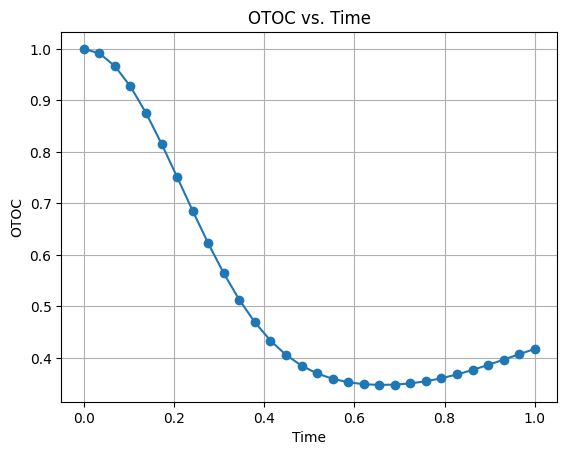

In [358]:
otoc_values = []

for t in time_points:
    # Evolve density matrix directly up to time t
    rho_t = evolve_density_matrix(rho_initial, H_full, H_sys, H_bath, t)
    
    # Partial trace over bath, keeping the "left" subsystem (the system)
    rho_sys = basis_total.partial_trace(
        rho_t, 
        sub_sys_A="left", 
        return_rdm="A", 
        enforce_pure=False
    )
    
    # Rényi-2 Entropy = -log(Tr(rho_sys^2))
    trace_rho_sys_sq = np.trace(rho_sys @ rho_sys)
    S2 = -np.log(trace_rho_sys_sq.real)  # ensure real part
    otoc_values.append(np.exp(-S2))

# Plot
plt.plot(time_points, otoc_values, 'o-')
plt.xlabel("Time")
plt.ylabel("OTOC")
plt.title("OTOC vs. Time")

plt.grid()
plt.show()

In [359]:
def heisenberg_picture(op, H, time):
        """Heisenberg-evolved operator: op(time) = e^{+iHt} op e^{-iHt}."""
        U = expm(+1j * H.toarray() * time)        
        Udag = U.conj().T              
        return U @ op.toarray() @ Udag

Function for two types of bath correlation functions:
$$
\begin{align}
    &\Gamma_{1}(t,s) = \langle b_{2}(s)b^{\dagger}_{2}(t)\rangle_{\rho_{B}}\\
    &\Gamma_{2}(t,s) = \langle b^{\dagger}_{2}(s)b_{2}(t)\rangle_{\rho_{B}}
\end{align}
$$

In [360]:
import numpy as np
from scipy.linalg import expm

def two_point_corr(H_bath, rho, b, bdag, t, s, corr_type):
    
    

    # Evolve operators in Heisenberg picture
    if corr_type == "b_bdag":
        # O1(t) = bdag(t), O2(s) = b(s)
        O1_t = heisenberg_picture(bdag, H_bath, t)
        O2_s = heisenberg_picture(b,    H_bath, s)
    elif corr_type == "bdag_b":
        # O1(t) = b(t), O2(s) = bdag(s)
        O1_t = heisenberg_picture(b,    H_bath, t)
        O2_s = heisenberg_picture(bdag, H_bath, s)
    else:
        raise ValueError("corr_type must be 'bdag_b' or 'b_bdag'.")

    # Compute the trace with respect to rho: Tr[ O1_t O2_s rho ]
    corr_val = np.trace(O2_s @ O1_t @ rho)
    return corr_val


Function for the Liouvillian superoperator:
$$
\begin{align*}
    \mathcal{H}(t)  &= J^{2}\int_{0}^{t} ds \, \Big[ \Gamma_{1}(t,s) \left\{ a^{\dagger}(s)\otimes a(t) - I\otimes a^{\dagger}(s)a(t) \right\} \nonumber \\
    &\quad + \Gamma_{1}^{*}(t,s) \left\{ a^{\dagger}(t)\otimes a(s) - a^{\dagger}(t)a(s)\otimes I \right\} \nonumber \\
    &\quad + \Gamma_{2}(t,s) \left\{ a(s)\otimes a^{\dagger}(t) - I\otimes a(s)a^{\dagger}(t) \right\} \nonumber \\
    &\quad + \Gamma_{2}^{*}(t,s) \left\{ a(t)\otimes a^{\dagger}(s) - a(t)a^{\dagger}(s)\otimes I \right\} \Big]
\end{align*}
$$

In [361]:
def liouv_superop(t1, t2, J, HB, HS, rho, A, B):
    bath_corr_1  = two_point_corr(HB, rho, A, B, t1, t2, "b_bdag")
    bath_corr_2  = two_point_corr(HB, rho, A, B, t1, t2, "bdag_b")
    
    create_sys_t1 = heisenberg_picture(create_sys, H_sys, t1)
    create_sys_t2 = heisenberg_picture(create_sys, H_sys, t2)
    
    annih_sys_t1 = heisenberg_picture(annih_sys, H_sys, t1)
    annih_sys_t2 = heisenberg_picture(annih_sys, H_sys, t2)
    
    I_liouv = np.eye(create_sys.toarray().shape[0])
    
    term1 = bath_corr_1 * ( np.kron(create_sys_t2, annih_sys_t1) - np.kron(I_liouv, create_sys_t2*annih_sys_t1) )
    term2 = np.conj(bath_corr_1) * ( np.kron(create_sys_t1, annih_sys_t2) - np.kron(create_sys_t1*annih_sys_t2, I_liouv) )
    term3 = bath_corr_2 * ( np.kron(annih_sys_t2, create_sys_t1) - np.kron(I_liouv, annih_sys_t2*create_sys_t1) )
    term4 = np.conj(bath_corr_2) * ( np.kron(annih_sys_t1, create_sys_t2) - np.kron(annih_sys_t1*create_sys_t2, I_liouv) )
    
    superop =  J*J*( term1 + term2 + term3 + term4)
    
    return superop - superop.conj().T
    

Function for the double nested integration required for QSL:
$$
\int_{0}^{t}dt\lVert\mathcal{H}(t)-\mathcal{H}^{\dagger}(t)\rVert_{sp}
$$

In [362]:
def liouv_spec_bound(t, J, H_bath, H_self, init_state, A, B):
    # Integrate liouv_superop with respect to x, then take the spectral norm, then integrate with respect to y
    def inner_integral(y):
        # Integrate liouv_superop with respect to x from 0 to y
        def integrand(x):
            return liouv_superop(y, x, J, H_bath, H_self, init_state, A, B)
        
        # Using quad_vec with specified tolerances for matrix-valued output
        integrated_superop, _ = integrate.quad_vec(integrand, 0, y, epsabs=1e-6, epsrel=1e-6)
        
        # Calculate spectral norm with np.linalg.norm (2-norm) and handle any small negative values
        spectral_norm = np.linalg.norm(integrated_superop, ord=2)
        return spectral_norm
    
    # Integrate the spectral norm over the outer bound with respect to y from 0 to t, with tolerances
    result, _ = integrate.quad(inner_integral, 0, t, epsabs=1e-6, epsrel=1e-6)
    return result

Now we compute the Liouville bound with and without Born approximation

In [ ]:
liouv_bound =[]
liouv_born_bound =[]

for t in time_points:
    rho_t = evolve_density_matrix(rho_initial, H_full, H_sys, H_bath, t)
    
    # Partial trace to obtain reduced bath state
    rho_b = basis_total.partial_trace(
        rho_t, 
        sub_sys_A="left", 
        return_rdm="B", 
        enforce_pure=False
    )
    
    
    # Calculate Redfield spectral bound
    red_bound = liouv_spec_bound(t, J, H_bath, H_sys, rho_b, create_bath, annih_bath)
    red_born_bound = liouv_spec_bound(t, J, H_bath, H_sys, rho_bath, create_bath, annih_bath)
    print(t)
    
    
    liouv_bound.append(red_bound)
    liouv_born_bound.append(red_born_bound)

    

0.0
0.034482758620689655
0.06896551724137931
0.10344827586206896
0.13793103448275862
0.1724137931034483
0.20689655172413793
0.24137931034482757
0.27586206896551724
0.3103448275862069


In [ ]:
bound1=[]
bound2=[]
bound3=[]
bound4=[]
bound5=[]

"""
for b in bound:
    bound1.append(np.exp(-2*b))
    
for b in born_bound:
    bound5.append(np.exp(-2*b))
    
"""
    
for b in liouv_bound:
    bound2.append(np.exp(-b))
    
for b in otoc_values:
    bound3.append(np.exp(-b))

for b in liouv_born_bound:
    bound4.append(np.exp(-b))
    
#plt.plot(tlist,bound1, label='Spectral bound')
plt.plot(time_points, otoc_values,label = 'OTOC', color = 'orange')
plt.plot(time_points, bound2,label = 'Liouv space', color='blue')

plt.plot(time_points, bound4,label = 'Liouv space + Born', color='green')

#plt.plot(tlist, bound1,label = 'State space', color = 'Red')
#plt.plot(tlist, bound5,label = 'State space + Born', color = 'Black')
plt.axhline(y=1/3 ,color='gray', linestyle='--', linewidth=1)

plt.ylabel('QSL')
plt.xlabel('time')
plt.title('Scrambling in TFIM')
plt.grid()
plt.legend()


In [ ]:
"""
# -------------------------
# Print Results
# -------------------------

# Print the Hamiltonian
print("Single-Site Bose-Hubbard Hamiltonian (matrix form):")
print(H_sys.toarray())

# Print the basis states for verification
print("\nBasis states (n values):")
for state in basis_sys.states:
    print(basis_sys.int_to_state(state))
"""